# Assignment 2
### Scientific Computing

Nitai Nijholt (12709018)

Pablo Rodriguez Alves (15310191)

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation

from math import floor
from time import sleep

In [2]:
# Module with diffusion code from Assignment 1
from diffusion_module import update_sor

In [3]:
np.random.seed(42)

## 1. Diffusion Limited Aggregation

### A.1 Implement growth model

In [5]:
# Global parameters
N = 50
ETA = 1
STEPS = 100
CONCENTRATION_SOLVING_THRESHOLD = 0.001 # For concentration solving

# Flags
SHOW_STARTING_CONDITIONS = True
SAVE_CLUSTER_EVOLUTION = True


In [9]:
# Innitialization
# of concentrations, cluster and candidate growth probabilities
concentrations = np.zeros((N,N))
cluster = np.zeros((N,N))
candidates = np.zeros((N,N))

## 1. Concentration is set to analytical result
for i in range(N):
    concentrations[i,:] = 1 - i/(N-1)

## 2. Innitial cluster is set as a small square at the bottom
# If we want a 2x2 square, use this: cluster[N-2:N,int(N/2-1):int(N/2+1)] = 1
cluster[N-1,int(N/2)] = 1

C:\Users\Pablo\AppData\Local\Temp\ipykernel_41084\2991715646.py:12: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("GnBu").copy()
  cmap.set_bad(color='black')


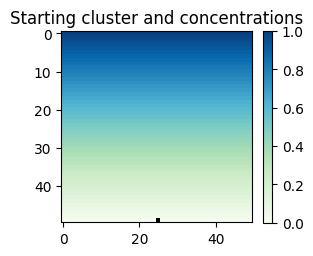

In [10]:
# Plotting of starting conditions
# Colorbar settings based on:
# https://stackoverflow.com/questions/37719304/python-imshow-set-certain-value-to-defined-color

if SHOW_STARTING_CONDITIONS:
    # Combine concentrations and cluster for showing
    lattice = concentrations + cluster
    masked_array = np.ma.masked_where(cluster == 1, lattice)
    
    # Select the colormap and the color for the exception values
    cmap = matplotlib.cm.GnBu
    cmap.set_bad(color='black')
    
    # Plot the total lattice
    # For exporting this to report, we should add dpi=400
    plt.figure(figsize=(3,3))
    plt.imshow(masked_array, cmap=cmap)
    plt.title('Starting cluster and concentrations')
    plt.colorbar(fraction=0.0455, pad=0.05)
    plt.tight_layout()
    plt.show()

In [11]:
# SOC solving until stop_thresold
def solve_SOR(concentrations,cluster,stop_thresold,N):

    # TODO: Move this to function parameters
    # TODO: Change w to optimal w
    MAX_ITERATIONS = 20
    w=1.8

    # At the top we have c=1, and c=0 at the bottom
    # TODO: Check if this is the case
    concentrations[0,:] = 1
    concentrations[N-1,:] = 0
    

    # Where we have our cluster it behaves as insulating material
    iteration = 1

    old_c = concentrations

    while(iteration < MAX_ITERATIONS):
        # TODO: Call sor_updated
        new_c = update_sor(old_c,cluster,N,w)        

        # TODO: Compute difference in concent.
        delta = np.max(np.abs(new_c - old_c))

        # TODO: Check if we change less than stop_thresold
        if delta < stop_thresold:
            break
        else:
            old_c = new_c
            iteration +=1
        


    # TODO: Implement as done in assignment 1
    return new_c

def is_neighboor_in_bounds(neighboor,N):
    x,y = neighboor
    return True if (x >= 0 and x < N and y >= 0 and y < N) else False

# Locate growth candidates
def get_candidates(cluster,N):
    # Reset candidates
    candidates = np.zeros((N,N))

    # Get neighboor cells of cluster
    cluster_cell_coordinates = np.argwhere(cluster != 0)

    for cell in cluster_cell_coordinates:
        # Check neighboors        
        x,y = cell

        neighboors = [[x+1,y],[x-1,y],[x,y+1],[x,y-1]]

        for neighboor in neighboors:
            xn,yn = neighboor
            if is_neighboor_in_bounds(neighboor,N):
                if cluster[xn,yn] != 1:
                    candidates[xn,yn] = 1
                    
        # add as candidate!

    return candidates

def get_candidate_probabilities(candidates,concentrations,N,eta):
    # Innitialize matrix for probabilities
    probability_growth = np.zeros((N,N))

    candidates_coordinates = np.argwhere(candidates != 0)

    # Get sum of concentrations at candidate points
    candidate_c_sum = np.sum(np.power(concentrations[candidates != 0],eta))    
    
    # Old way
    #candidate_c_sum = 0
    #for cell in candidates_coordinates:
    #    x,y = cell
    #    candidate_c_sum += concentrations[x,y]**eta

    # Iterate all candidates!
    # TODO: Optimize This could again be done with numpy syntax in one line
    for cell in candidates_coordinates:
        x,y = cell
        probability_growth[x,y] = np.power(concentrations[x,y],eta) / candidate_c_sum

    return probability_growth

def coordinates_chosen_one(candidates,probability_growth,N):
    # Get candidates in 1D and probabilities in 1D
    cands = np.arange(0, N**2)
    probs = probability_growth.ravel()

    #print(cands,probs)

    choice = np.random.choice(cands,p=probs)
    
    #print(choice)
    # Get coordinates of element choice
    
    # Get coordinate
    x = floor(choice/N)
    y = choice % N
    return x,y

# Choose one candidate
# Update the cluster with that value


In [12]:
def update(cluster,concentrations,stop_thresold,N):
    # 1. Solve time-indep Eq (like Laplace)
    ## 1.1 Make concentrations at cluster be 0
    concentrations[cluster==1] = 0

    ## 1.2 Solve concentrations!
    concentrations = solve_SOR(concentrations,cluster,stop_thresold,N)
    
    # 2. Locate growth candidates around cluster
    candidates = get_candidates(cluster,N)
    probability_growth = get_candidate_probabilities(candidates,concentrations,N,ETA)

    """
    print(candidates)
    print(probability_growth)
    plt.imshow(probability_growth)
    plt.show()
    """

    # 3. A single candidate is added with probability p_g
    x,y = coordinates_chosen_one(candidates,probability_growth,N)
    
    # And then it is added to the cluster
    cluster[x,y] = 1

    return cluster,concentrations,probability_growth



In [13]:
# Repeat from 1 for a large number of growh_steps

if SAVE_CLUSTER_EVOLUTION:
    # Prepare to save all clusters
    total_clusters = np.zeros((N,N,STEPS))
    total_concentrations = np.zeros((N,N,STEPS))
    total_probability_growth = np.zeros((N,N,STEPS))
    # Save starting cluster
    total_clusters[:,:,0] = cluster

# Main simulation loop
for step in range(STEPS-1):
    
    cluster,concentrations,probability_growth = update(cluster,concentrations,CONCENTRATION_SOLVING_THRESHOLD,N)

    if SAVE_CLUSTER_EVOLUTION:
        total_clusters[:,:,step+1] = cluster
        total_concentrations[:,:,step+1] = concentrations
        total_probability_growth[:,:,step+1] = probability_growth

In [14]:
# Save results
if SAVE_CLUSTER_EVOLUTION:
    np.save(f'DLA_clusters_{N}_{STEPS}_{CONCENTRATION_SOLVING_THRESHOLD}.npy',total_clusters)
    np.save(f'DLA_concents_{N}_{STEPS}_{CONCENTRATION_SOLVING_THRESHOLD}.npy',total_concentrations)
    np.save(f'DLA_probabil_{N}_{STEPS}_{CONCENTRATION_SOLVING_THRESHOLD}.npy',total_probability_growth)

In [15]:
# Load results
total_clusters = np.load(f'DLA_clusters_{N}_{STEPS}_{CONCENTRATION_SOLVING_THRESHOLD}.npy')
total_concentrations = np.load(f'DLA_concents_{N}_{STEPS}_{CONCENTRATION_SOLVING_THRESHOLD}.npy')
total_probability_growth = np.load(f'DLA_probabil_{N}_{STEPS}_{CONCENTRATION_SOLVING_THRESHOLD}.npy')

C:\Users\Pablo\AppData\Local\Temp\ipykernel_36756\3635163997.py:7: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("GnBu").copy()
  cmap.set_bad(color='black')


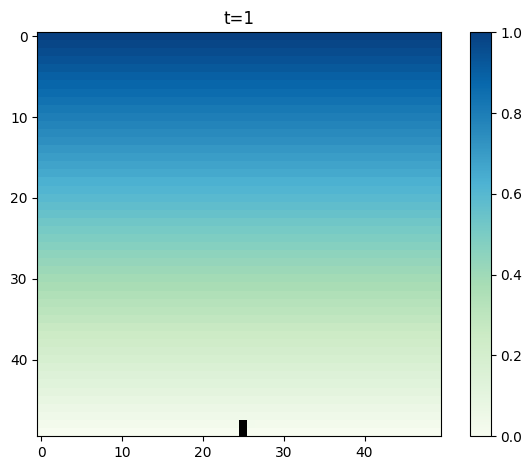

In [36]:
t=1
lattice = total_concentrations[:,:,t] + total_clusters[:,:,t]
masked_array = np.ma.masked_where(total_clusters[:,:,t] == 1, lattice)

# Select the colormap and the color for the exception values
cmap = matplotlib.cm.GnBu
cmap.set_bad(color='black')        

# Plot the total lattice
plt.imshow(masked_array, cmap=cmap)
plt.title(f't={t}')
plt.colorbar(fraction=0.0455, pad=0.05)
plt.tight_layout()

In [28]:
# Function for animation of cluster and concentration, based on Assignment 1
def save_animation(clusters,concentrations, interval=250,fps=10,name='animation.mp4'):
        
    plt.figure(figsize=(3, 3), layout='tight')

    def update(t):
        plt.clf()
        
        lattice = concentrations[:,:,t] + clusters[:,:,t]
        masked_array = np.ma.masked_where(clusters[:,:,t] == 1, lattice)
        
        # Select the colormap and the color for the exception values
        cmap = matplotlib.cm.GnBu
        cmap.set_bad(color='black')        

        # Plot the total lattice
        plt.imshow(masked_array, cmap=cmap)
        plt.title(f't={t}')
        plt.colorbar(fraction=0.0455, pad=0.05)
        plt.tight_layout()
        return plt

    anim = animation.FuncAnimation(plt.gcf(), update, frames=range(
            0, clusters.shape[2]), interval=interval)

    writer = animation.FFMpegWriter(fps=fps)
    anim.save(name, writer = writer)

In [21]:
# Function for animation of growth probability
def save_animation_probability(clusters,growth_probs, interval=250,fps=10,name='animation_probability.mp4',normalize=False):
        
    plt.figure(figsize=(3, 3), layout='tight')

    def update(t):
        plt.clf()
        
        lattice = growth_probs[:,:,t] + clusters[:,:,t]
        masked_array = np.ma.masked_where(clusters[:,:,t] == 1, lattice)
        
        # Select the colormap and the color for the exception values
        cmap = matplotlib.cm.GnBu
        cmap.set_bad(color='black')        

        # Plot the total lattice
        if normalize:
            masked_array = masked_array / np.max(growth_probs[:,:,t])

        plt.imshow(masked_array, cmap=cmap)
        plt.title(f't={t}')
        plt.colorbar(fraction=0.0455, pad=0.05)
        plt.tight_layout()
        return plt

    anim = animation.FuncAnimation(plt.gcf(), update, frames=range(
            0, clusters.shape[2]), interval=interval)

    writer = animation.FFMpegWriter(fps=fps)
    anim.save(name, writer = writer)

In [22]:
save_animation(total_clusters,total_concentrations, interval=250,fps=30,name=f'animation_{N}_{STEPS}_{CONCENTRATION_SOLVING_THRESHOLD}.mp4')

NameError: name 'save_animation' is not defined

C:\Users\Pablo\AppData\Local\Temp\ipykernel_41084\782321486.py:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("GnBu").copy()
  cmap.set_bad(color='black')


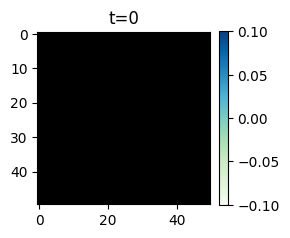

In [23]:
# Growth probability animation
save_animation_probability(total_clusters,total_probability_growth, interval=250,fps=30,name=f'animation_prob_{N}_{STEPS}_{CONCENTRATION_SOLVING_THRESHOLD}.mp4',normalize=True)
      

### A.2 Run a number of growth simulations

In [ ]:
# TODO


### A.3 Investigate the influence of the $\tau$ parameter

In [ ]:
# TODO


### OPTIONAL - Reduce the time required to solve the diffusion equation

In [ ]:
# TODO

## 2. Monte Carlo Simulation of DLA

### B.1 Implement the Monte Carlo version of DLA

In [ ]:
# TODO

### B.2 Compare the resulting cluster to those obtained with the diffusion equation

In [ ]:
# TODO

### C.1 Run the simulation for different values of $p_s$

In [ ]:
# TODO

### C.2 Plot the results

In [ ]:
# TODO

### C.3 How does cluster shape depend on $p_s$?

In [ ]:
# TODO

## 3. The Gray-Scott model

### D.1 Implement the Gray-Scott model in 2D

In [ ]:
# TODO

### D.2 Explain the discretization and implementation

In [ ]:
# TODO

### D.3 Plot the resulting concentrations of U and V for several parameter choices

In [ ]:
# TODO

### D.4 Try adding a small amount of noise

In [ ]:
# TODO